In [11]:
#CELL 1: IMPORTS

import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0


In [12]:
#CELL 2: DATASET PATHS 

DATASET_PATH = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original"
SPECTROGRAM_PATH = "/kaggle/working/spectrograms"

os.makedirs(SPECTROGRAM_PATH, exist_ok=True)
print("Dataset path OK")


Dataset path OK


In [14]:
#CELL 3: MEL-SPECTROGRAM FUNCTION

def create_mel_spectrogram(audio_path, save_path):
    y, sr = librosa.load(audio_path, duration=20)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    plt.figure(figsize=(3,3))
    librosa.display.specshow(mel_db, sr=sr)
    plt.axis("off")
    plt.savefig(save_path, bbox_inches="tight", pad_inches=0)
    plt.close()


In [15]:
# CELL 4: GENERATE MEL-SPECTROGRAMS

skipped = 0
genres = os.listdir(DATASET_PATH)

for genre in genres:
    in_dir = os.path.join(DATASET_PATH, genre)
    out_dir = os.path.join(SPECTROGRAM_PATH, genre)
    os.makedirs(out_dir, exist_ok=True)

    for i, file in enumerate(os.listdir(in_dir)):
        try:
            create_mel_spectrogram(
                os.path.join(in_dir, file),
                os.path.join(out_dir, f"{genre}_{i}.png")
            )
        except:
            skipped += 1

print("Done. Skipped files:", skipped)


/tmp/ipykernel_55/1447368830.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, duration=20)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Done. Skipped files: 1


In [23]:
# CELL 5: LOAD DATA 

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_data = datagen.flow_from_directory(
    SPECTROGRAM_PATH,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_data = datagen.flow_from_directory(
    SPECTROGRAM_PATH,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

class_names = list(train_data.class_indices.keys())
print(class_names)



Found 800 images belonging to 10 classes.
Found 199 images belonging to 10 classes.
['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [34]:
# CELL 6: BUILD MODEL (STAGE 1)

base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

for layer in base_model.layers:
    layer.trainable = False

#x = GlobalAveragePooling2D()(base_model.output)
#x = Dropout(0.5)(x)
#output = Dense(10, activation="softmax")(x)

#model = Model(base_model.input, output)

#model.compile(
 #   optimizer="adam",
 #   loss="categorical_crossentropy",
 #   metrics=["accuracy"]
#)

#model.summary()
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(10, activation="softmax")(x)

model = Model(base_model.input, output)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [35]:
# CELL 7: TRAIN STAGE 1 (HEAD ONLY)

# 🔓 Unfreeze last 30 layers ONLY
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # VERY SMALL LR
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    train_data,
    epochs=5,
    validation_data=val_data
)


Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 543ms/step - accuracy: 0.1164 - loss: 2.3731 - val_accuracy: 0.0955 - val_loss: 2.3340
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.1095 - loss: 2.3615 - val_accuracy: 0.0955 - val_loss: 2.3300
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.0879 - loss: 2.3675 - val_accuracy: 0.0955 - val_loss: 2.3259
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.0971 - loss: 2.3584 - val_accuracy: 0.0955 - val_loss: 2.3227
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.1046 - loss: 2.3575 - val_accuracy: 0.0955 - val_loss: 2.3202


In [30]:
# CELL 8: FINE-TUNE (STAGE 2 – IMPORTANT)

for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [31]:
# CELL 9: TRAIN STAGE 2
model.fit(
    train_data,
    epochs=15,
    validation_data=val_data
)


Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 38s 536ms/step - accuracy: 0.1018 - loss: 2.3725 - val_accuracy: 0.1809 - val_loss: 2.3095
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.0905 - loss: 2.3584 - val_accuracy: 0.1005 - val_loss: 2.3103
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.1113 - loss: 2.3552 - val_accuracy: 0.1005 - val_loss: 2.3115
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.0966 - loss: 2.3667 - val_accuracy: 0.1005 - val_loss: 2.3132
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.0962 - loss: 2.3200 - val_accuracy: 0.1508 - val_loss: 2.3148
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.1160 - loss: 2.3590 - val_accuracy: 0.1005 - val_loss: 2.3156
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.0817 - loss: 2.3406 - val_accuracy: 0.1005 - val_loss: 2.3158
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.1195 - loss: 2.3566 - val_accuracy: 0

In [36]:
# CELL 10: EVALUATE

loss, acc = model.evaluate(val_data)
print("Validation Accuracy:", acc)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.0696 - loss: 2.4140 
Validation Accuracy: 0.0954773873090744


7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step


<Axes: >

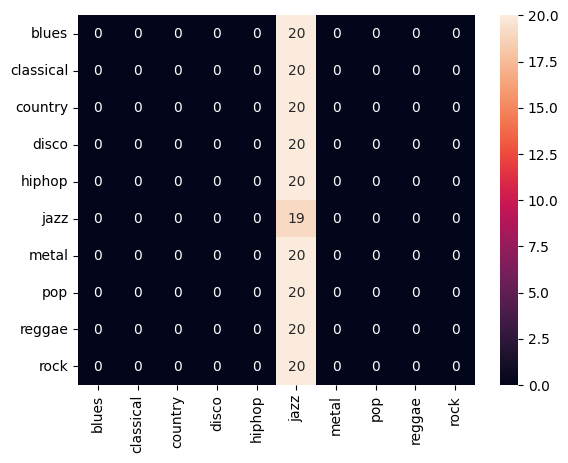

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict all validation data
val_data.reset()  # Important
preds_all = model.predict(val_data)
y_pred = np.argmax(preds_all, axis=1)
y_true = val_data.classes

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
